# TP4: Decision trees & random forests
The aim of this tutorial is to get familiar with the use of decision trees and their generalizations on simple examples using `scikit-learn` tools.

## Completing your installation first
You will need to install packages `python-graphviz` first. If needed, uncomment the `conda` command below:

In [1]:
# If needed, uncomment the line below:
# install python-graphviz

In [2]:
# # Add graphviz to path
import os
os.environ["PATH"] += os.pathsep + 'C:\Program Files (x86)\Graphviz2.38\bin'

In [3]:
from pylab import *
import matplotlib.pyplot as plt

# Load the library with the iris dataset
from sklearn.datasets import load_iris, load_wine



# Load scikit's decision tree classifier
from sklearn import tree

# Load scikit's random forest classifier library
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

# To visualize trees
import graphviz 


# Load pandas to manipulate data frames (Excel like)
import pandas as pd

# Load numpy
import numpy as np

# Set random seed
np.random.seed(0)

# Load seaborn
import seaborn as sns

The data for this tutorial is famous. Called, **the iris dataset**, it contains four variables measuring various parts of iris flowers of three related species, and then a fourth variable with the species name. The reason it is so famous in machine learning and statistics communities is because the data requires very little preprocessing (i.e. no missing values, all features are floating numbers, etc.).

In [4]:
iris = load_iris()

## Step 1: explore the data set
1. What is the structure of the object `iris` ?

2. Plot this dataset in a well chosen set of representations to explore the data.

---

1. This data sets consists of 3 different types of irises’ (Setosa, Versicolour, and Virginica) petal and sepal length, stored in a 150x4 numpy.ndarray. The rows being the samples and the columns being: Sepal Length, Sepal Width, Petal Length and Petal Width.  
It contains 2 arrays : one with the numerical data, the other with the targets data.  
It also contains the features name and target name.  
Finally it has a description of the dataset : author, date and a short description of the data.

---

2.

In [5]:
from sklearn import preprocessing

Let's scale the data (mean = 0 and standard variation = 1).

In [6]:
iris_scaled = preprocessing.scale(iris.data)

Let's compute the covariance matrix of the scaled data to see how the features are correlated.

In [7]:
cov_iris = np.cov(iris_scaled.T)

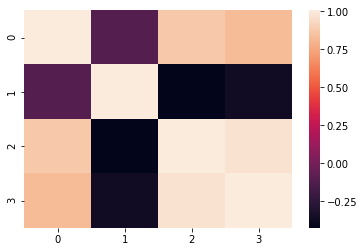

In [8]:
sns.heatmap(cov_iris)
plt.show()

This heatmap shows several things at first glance:  
- The petal features are strongly correlated (width and length); these attributes could be the two first principal components used in PCA;
- The sepal width is not correlated at all with the rest of the features; as such, it will be virtually useless to classify the species;
- The sepal length is somewhat correlated with the petal features but to a lesser extent.

Let's us showcase these first results: 

In [9]:
iris0 = iris.data[iris.target == 0]
iris1 = iris.data[iris.target == 1]
iris2 = iris.data[iris.target == 2]

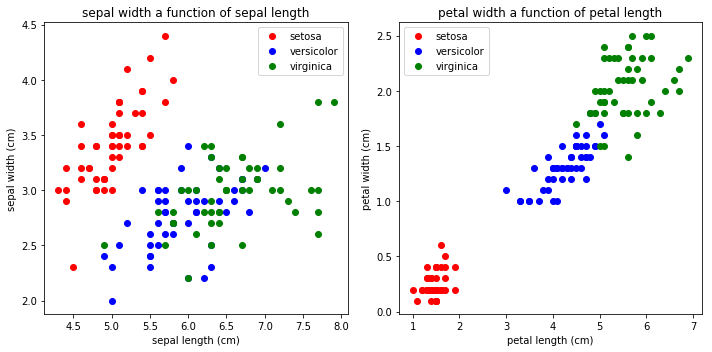

In [10]:
plt.rcParams['figure.figsize'] = [10,5]

plt.subplot(1,2,1)
plt.plot(iris0[:,0], iris0[:,1], 'ro', label = 'setosa')
plt.plot(iris1[:,0], iris1[:,1], 'bo', label = 'versicolor')
plt.plot(iris2[:,0], iris2[:,1], 'go', label = 'virginica')
plt.xlabel('sepal length (cm)')
plt.ylabel('sepal width (cm)')
plt.title('sepal width a function of sepal length')
plt.legend(loc = 'upper right')

plt.subplot(1,2,2)
plt.plot(iris0[:,2], iris0[:,3], 'ro', label = 'setosa')
plt.plot(iris1[:,2], iris1[:,3], 'bo', label = 'versicolor')
plt.plot(iris2[:,2], iris2[:,3], 'go', label = 'virginica')
plt.xlabel('petal length (cm)')
plt.ylabel('petal width (cm)')
plt.title('petal width a function of petal length')
plt.legend(loc = 'upper left')

plt.tight_layout()
plt.show()

Comparing sepal length and width shows a clear separation between setosae and the 2 other species.  
The plot showing petal width an length shows that a projection on either petal length or petal width gives a good clustering.  
On the other hand projecting on sepal width won't allow us to cluster the species very well (this result is in accordance with the covariance results).

## Using `pandas` to manipulate the data
Pandas is great to manipulate data in a Microsoft Excel like way.

In [11]:
import pandas as pd

# Create a dataframe with the four feature variables
df = pd.DataFrame(iris.data, columns=iris.feature_names)

# View the top 5 rows
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [12]:
# Add a new column with the species names, this is what we are going to try to predict
df['species'] = pd.Categorical.from_codes(iris.target, iris.target_names)

# View the top 5 rows
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


## Step 2: create training and test sets

Create a new column that for each row, generates a random number between 0 and 1, and if that value is less than or equal to .75, then sets the value of that cell as True and false otherwise. This is a quick and dirty way of randomly assigning some rows to be used as the training data and some as the test data.

In [13]:
df['is_train'] = np.random.uniform(0, 1, len(df)) <= .75

# View the top 5 rows
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species,is_train
0,5.1,3.5,1.4,0.2,setosa,True
1,4.9,3.0,1.4,0.2,setosa,True
2,4.7,3.2,1.3,0.2,setosa,True
3,4.6,3.1,1.5,0.2,setosa,True
4,5.0,3.6,1.4,0.2,setosa,True


In [14]:
# Create two new dataframes, one with the training rows, one with the test rows
train, test = df[df['is_train']==True], df[df['is_train']==False]

In [15]:
# Show the number of observations for the test and training dataframes
print('Number of observations in the training data:', len(train))
print('Number of observations in the test data:',len(test))

Number of observations in the training data: 118
Number of observations in the test data: 32


In [16]:
# Create a list of the feature column's names
features = df.columns[:4]

# View features
features

Index(['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)',
       'petal width (cm)'],
      dtype='object')

In [17]:
# train['species'] contains the actual species names. Before we can use it,
# we need to convert each species name into a digit. So, in this case there
# are three species, which have been coded as 0, 1, or 2.
y = pd.factorize(train['species'])[0]

## Step 3: decision trees for the iris dataset
The method `tree.DecisionTreeClassifier()` from `scikit-learn` builds decision trees objects as follows:

In [18]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(train[features], y)

# Using the whole dataset you may use directly:
#clf = clf.fit(iris.data, iris.target)

The `export_graphviz` exporter supports a variety of aesthetic options, including coloring nodes by their class (or value for regression) and using explicit variable and class names if desired. Jupyter notebooks also render these plots inline automatically:

In [19]:
dot_data = tree.export_graphviz(clf, out_file=None, 
                         feature_names=iris.feature_names,  
                         class_names=iris.target_names,  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = graphviz.Source(dot_data)  
graph 

ExecutableNotFound: failed to execute ['dot', '-Tsvg'], make sure the Graphviz executables are on your systems' PATH

We can also export the tree in Graphviz format and  save the resulting graph in an output file iris.pdf:

In [20]:
dot_data = tree.export_graphviz(clf, out_file=None) 
graph = graphviz.Source(dot_data) 
graph.render("iris") 

ExecutableNotFound: failed to execute ['dot', '-Tpdf', '-O', 'iris'], make sure the Graphviz executables are on your systems' PATH

After being fitted, **the model can then be used to predict the class of samples**:

In [21]:
class_pred = clf.predict(iris.data[:1, :])
class_pred

array([0], dtype=int64)

## Exercise 1
1. Train the decision tree on the iris dataset and explain how one should read blocks in `graphviz` representation of the tree.

2. Plot the regions of decision with the points of the training set superimposed.

*Indication: you may find the function `plt.contourf` useful.

---
At each node a binary decision is made on how to separate the dataset into two new datasets, the children nodes. The separation criterion is chosen using the Gini index by default: $\sum_{k=1}^{K}p_{m,k}(1 - p_{m,k}) $. If we code each observation as 1 for class $k$ and zero otherwise, the Gini criterion can be interpreted as the sum of variances over all classes.   
We could use a different node impurity measure (misclassification rate or cross-entropy for instance).  
  
1. This tree should be read from top to bottom. We can notice that, for a given node, as long as the samples are of different classes we continue splitting the data. We reach a leaf when all the samples are of the same class. We can change this behaviour using the the  `min_samples_leaf` parameter to train the model (default = 1).   
For each new value we want to predict,  we check at each note whether it verifies the assertion. It it does, we continue testing the value on the left child, if it doesn't, we continue on the right child. We iterate the check until we reach a leaf.  The class of the leaf gives the value its predicted class.

In [ ]:
for pairidx, pair in enumerate([[0, 1], [0, 2], [0, 3],
                                [1, 2], [1, 3], [2, 3]]):
    print(pairidx, pair)

In [ ]:
# plt.rcParams['figure.figsize'] = [15,10]

# # Parameters
# n_classes = 3
# plot_colors = "ryb"
# plot_step = 0.02

# # pairidx is the index of the combination between all features 
# # pair takes the indices of the features combined
# for pairidx, pair in enumerate([[0, 1], [0, 2], [0, 3],
#                                 [1, 2], [1, 3], [2, 3]]):
    
#     # We only take the two corresponding features
#     X = iris.data[:, pair]
#     y = iris.target

#     # Train
#     clf = tree.DecisionTreeClassifier().fit(X, y)

#     # Plot the decision boundary
#     plt.subplot(2, 3, pairidx + 1)

#     x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
#     y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
#     xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
#                          np.arange(y_min, y_max, plot_step))
#     plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

#     Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
#     Z = Z.reshape(xx.shape)
#     cs = plt.contourf(xx, yy, Z, cmap=plt.cm.RdYlBu)

#     plt.xlabel(iris.feature_names[pair[0]])
#     plt.ylabel(iris.feature_names[pair[1]])

#     # Plot the training points
#     for i, color in zip(range(n_classes), plot_colors):
#         idx = np.where(y == i)
#         plt.scatter(X[idx, 0], X[idx, 1], c=color, label=iris.target_names[i],
#                     cmap=plt.cm.RdYlBu, edgecolor='black', s=8)

# plt.suptitle("Decision surface of a decision tree using paired features")
# plt.legend(loc='lower right', borderpad=0, handletextpad=0)
# plt.axis("tight")
# plt.show()

ValueError: cannot reshape array of size 220 into shape (220,220)

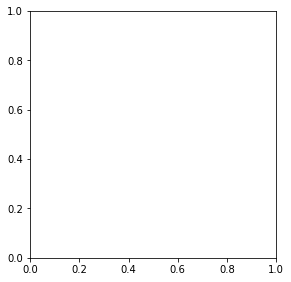

In [54]:
plt.rcParams['figure.figsize'] = [15,10]

# Parameters
n_classes = 3
plot_colors = "ryb"
plot_step = 0.02


    
# We only take the two corresponding features
X = train[features]
#y = iris.target

# Train
#clf = tree.DecisionTreeClassifier().fit(X, y)

# Define the decision boundary


x1_min, x1_max = X['sepal length (cm)'].min() - 1, X['sepal length (cm)'].max() + 1
x2_min, x2_max = X['sepal width (cm)'].min() - 1, X['sepal width (cm)'].max() + 1
x3_min, x3_max = X['petal length (cm)'].min() - 1, X['petal length (cm)'].max() + 1
x4_min, x4_max = X['petal width (cm)'].min() - 1, X['petal width (cm)'].max() + 1

x_min = min(x1_min, x2_min, x3_min, x4_min)
x_max = min(x1_max, x2_max, x3_max, x4_max)

xx = np.meshgrid(np.arange(x_min, x_max, plot_step),
                     np.arange(x_min, x_max, plot_step), 
                     np.arange(x_min, x_max, plot_step),
                     np.arange(x_min, x_max, plot_step), sparse = True)

plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

Z = clf.predict(np.c_[xx[0].ravel(), xx[1].ravel(), xx[2].ravel(), xx[3].ravel()])


# pairidx is the index of the combination between all features 
# pair takes the indices of the features combined
for pairidx, pair in enumerate([[0, 1], [0, 2], [0, 3],
                            [1, 2], [1, 3], [2, 3]]):
  
    plt.subplot(2, 3, pairidx + 1)
    
    Z = Z.reshape((220,220))
    cs = plt.contourf(xx[pair[0]], xx[pair[1]], Z, cmap=plt.cm.RdYlBu)

    plt.xlabel(iris.feature_names[pair[0]])
    plt.ylabel(iris.feature_names[pair[1]])

# Plot the training points
for i, color in zip(range(n_classes), plot_colors):
    idx = np.where(y == i)
    plt.scatter(X[idx, 0], X[idx, 1], c=color, label=iris.target_names[i],
                cmap=plt.cm.RdYlBu, edgecolor='black', s=8)

plt.suptitle("Decision surface of a decision tree using paired features")
plt.legend(loc='lower right', borderpad=0, handletextpad=0)
plt.axis("tight")
plt.show()

In [51]:
xx[0].shape

(1, 220, 1, 1)

In [52]:
xx[1].shape

(220, 1, 1, 1)

In [53]:
xx[2].shape

(1, 1, 220, 1)

In [48]:
xx[3].shape

(1, 1, 1, 220)

In [58]:
Z = clf.predict(np.c_[xx[0].ravel(), xx[1].ravel(), xx[2].ravel(), xx[3].ravel()])

In [59]:
Z.shape

(220,)

## Exercise 2
1. Build 2 different trees based on a sepal features (sepal lengths, sepal widths) vs petal features (petal lengths, petal widths) only: which features are the most discriminant?

2. Compare performances with those obtained using all features.

3. Try the same as above using the various splitting criterion available, Gini's index, classification error or cross-entropy. Comment on your results. 

### Going further ahead (not mandatory) 
Try the same approach adapted to another toy dataset from `scikit-learn` described at:
http://scikit-learn.org/stable/datasets/index.html

Play with another dataset available at:
http://archive.ics.uci.edu/ml/datasets.html

## Step 4: Random forests
Go to 

http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html 

for a documentation about the `RandomForestClassifier` provided by `scikit-learn`.

Since target values must be integers, we first need to transform labels into numbers as below.

In [ ]:
# train['species'] contains the actual species names. Before we can use it,
# we need to convert each species name into a digit. So, in this case there
# are three species, which have been coded as 0, 1, or 2.
y = pd.factorize(train['species'])[0]

# View target
y

In [ ]:
# Create a random forest Classifier. By convention, clf means 'Classifier'
rf = RandomForestClassifier(n_jobs=2, random_state=0)

# Train the Classifier to take the training features and learn how they relate
# to the training y (the species)
rf.fit(train[features], y)

**Make predictions** and create actual english names for the plants for each predicted plant class:

In [ ]:
preds = rf.predict(test[features])
preds_names = pd.Categorical.from_codes(preds, iris.target_names)
preds_names

### Create a confusion matrix

In [ ]:
# Create confusion matrix unsing pandas:
pd.crosstab(test['species'], preds, rownames=['Actual Species'], colnames=['Predicted Species'])

## Feature selection using random forests byproducts

One of the interesting use cases for random forest is feature selection. One of the byproducts of trying lots of decision tree variations is that you can examine which variables are working best/worst in each tree.

When a certain tree uses one variable and another doesn't, you can compare the value lost or gained from the inclusion/exclusion of that variable. The good random forest implementations are going to do that for you, so all you need to do is know which method or variable to look at.

### View feature importance
While we don't get regression coefficients like with ordinary least squares (OLS), we do get a score telling us how important each feature was in classifying. This is one of the most powerful parts of random forests, because we can clearly see that petal width was more important in classification than sepal width.


In [ ]:
# View a list of the features and their importance scores
list(zip(train[features], rf.feature_importances_))

## Exercise 3
1. Comment on the feature importances with respect to your previous observations on decision trees above.

2. Extract and visualize 5 trees belonging to the random forest using the attribute `estimators_` of the trained random forest classifier. Compare them. *Note that you may code a loop on extracted trees.*

3. Study the influence of parameters like `max_depth`, `min_samples_leaf` and `min_samples_split`. Try to optimize them and explain your approach and choices.

4. How is estimated the prediction error of a random forest ?
*Indication: have a look at parameter `oob_score`.*
What are out-of-bag samples ?

5. What should you do when classes are not balanced in the dataset ? (that is when there are much more examples of one class than another)

## Step 5: a small example of regression using random forests
Random forest is capable of learning without carefully crafted data transformations. Take the the $f(x) = \sin(x)$ function for example.

Create some fake data and add a little noise.

In [ ]:
x = np.random.uniform(-2.5, 2.5, 1000)
y = np.sin(x) + np.random.normal(0, .1, 1000)

plt.plot(x,y,'ko',markersize=1,label='data')
plt.plot(np.arange(-2.5,2.5,0.1),np.sin(np.arange(-2.5,2.5,0.1)),'r-',label='ref')
plt.show()

If we try and build a basic linear model to predict y using x we end up with a straight line that sort of bisects the sin(x) function. Whereas if we use a random forest, it does a much better job of approximating the sin(x) curve and we get something that looks much more like the true function.

Based on this example, we will illustrate how the random forest isn't bound by linear constraints.

## Exercise 4
1. Apply random forests on this dataset for regression and compare performances with ordinary least squares regression.
*Note that ordinay least square regression is available thanks to:
from sklearn.linear_model import LinearRegression*

2. Comment on your results.

### Indications:
You may use half of points for training and others to test predictions. Then you will have an idea of how far the random forest predictor fits the sinus curve.

To this aim, you will need to use the model `RandomForestRegressor`. Be careful that when only 1 feature `x` is used as an input, you will need to reshape it by `x.reshape(-1,1)` when using methods `fit` and `predict`.

In [ ]:
regrf = RandomForestRegressor(n_estimators=30, max_depth=4)
regrf.fit(x[0::2].reshape(-1, 1),y[0::2])

In [ ]:
from sklearn.linear_model import LinearRegression
...

### Indication
One clever way to compare models when using `scikit-learn`is to make a loop on models as follows:

In [ ]:
models = [DecisionTreeClassifier(max_depth=None),
          RandomForestClassifier(n_estimators=n_estimators)]

for model in models:
    ...
    


## Documentation

### Decision trees
http://scikit-learn.org/stable/modules/tree.html

### Random forests
http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

### Plot decision surface : using `plt.contourf`
http://scikit-learn.org/stable/auto_examples/tree/plot_iris.html#sphx-glr-auto-examples-tree-plot-iris-py


## Pruning trees: not available in scikit-learn.
Since post-pruning of tree is not implemented in scikit-learn, you may think of coding your own pruning function. For instance, taking into account the numer of samples per leaf as proposed below:

In [ ]:
# Pruning function (useful ?)
def prune(decisiontree, min_samples_leaf = 1):
    if decisiontree.min_samples_leaf >= min_samples_leaf:
        raise Exception('Tree already more pruned')
    else:
        decisiontree.min_samples_leaf = min_samples_leaf
        tree = decisiontree.tree_
        for i in range(tree.node_count):
            n_samples = tree.n_node_samples[i]
            if n_samples <= min_samples_leaf:
                tree.children_left[i]=-1
                tree.children_right[i]=-1
                